# **Caso práctico 1: Análisis de tweets**

Análisis de tweets de este dataset https://github.com/garnachod/TwitterSentimentDataset

## 1. Cargar y explorar los datos

In [89]:
import pandas as pd

dataset = pd.read_csv("datos/tweets_en_es.csv")
dataset = dataset.sample(frac=1.0) ; dataset.head()

,Unnamed: 0,text,source
115467,60107,Me encanta paliarlo a Alan lástima q no esta a...,tweets_neg_clean.txt
113255,57895,@annekannushka es una plaga esto :(\n,tweets_neg_clean.txt
45217,45217,Fnatic no perdona esta segunda partida e igual...,tweets_pos_clean.txt
72690,17330,Te odio :( https://t.co/fJgHAdY2se\n,tweets_neg_clean.txt
80870,25510,Mi amor te traje un perrito ¿ PEKINES? _____ p...,tweets_neg_clean.txt


In [90]:
import rubrix as rb

records = [
    rb.TextClassificationRecord(
        inputs=row.text,
        metadata={"source": row.source}
    )
    for i,row in dataset[0:5000].iterrows()
]

rb.delete(name="tuits_en_es")

output = rb.log(records, name="tuits_en_es")


5000 records logged to http://localhost:6900/tuits_en_es


BulkResponse(dataset='tuits_en_es', processed=5000, failed=0)

## 2. Análisis de sentimiento

Usaremos `pysentimiento` (https://github.com/pysentimiento/pysentimiento). Entrenado originalmente con datasets de Tweets. 

Creado por **Juan Manuel Pérez** (https://twitter.com/perezjotaeme)


In [91]:
from pysentimiento import SentimentAnalyzer
from pysentimiento.preprocessing import preprocess_tweet

analyzer = SentimentAnalyzer(lang="es")
analyzer.predict(dataset.iloc[1].text).probas.items()

In [97]:
records = [
    rb.TextClassificationRecord(
        inputs=preprocess_tweet(row.text),
        metadata={"source": row.source},
        prediction=[
            pred 
            for pred in analyzer.predict(preprocess_tweet(row.text)).probas.items()
        ]
    )
    for i,row in dataset[0:100].iterrows()
]
rb.delete(name="tuits_en_es")
_ = rb.log(records, name="tuits_en_es")


100 records logged to http://localhost:6900/tuits_en_es


In [102]:
from rubrix.metrics.text_classification import f1

f1(name="tuits_en_es") #  query="metadata.source:tweets_pos_clean.txt"

MetricSummary(data={})

## 3. Análisis de emociones

Creado por **Juan Manuel Pérez** (https://twitter.com/perezjotaeme).

Ahora usaremos Hugging Face directamente.

In [ ]:
from transformers import pipeline
from datasets import Dataset

classifier = pipeline(
    "text-classification",
    model="finiteautomata/beto-emotion-analysis", 
    return_all_scores=True
)

dataset = Dataset.from_csv("datos/tweets_en_es.csv")
dataset = dataset.select(range(0,50)) 

In [129]:
rb.delete("tweets_en_es_emocion")
classifier = rb.monitor(classifier, dataset="tweets_en_es_emocion", sample_rate=1.0)

In [130]:
dataset.map(
    lambda r: {"prediction": classifier(r["text"])},
)

Dataset({
    features: ['Unnamed: 0', 'prediction', 'source', 'text'],
    num_rows: 50
})

## 4. Categorización de texto (modelo "zero-shot")

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", 
                       model="Recognai/zeroshot_selectra_medium")

labels = ["amistad", "política", "videojuegos", "deporte", "comida", "famosos", "música"]
template = "Este mensaje es sobre {}"

classifier = rb.monitor(classifier, dataset="tweets_en_es_categorizacion", sample_rate=1.0)

rb.delete("tweets_en_es_categorizacion")

In [134]:
classifier("Te quiero amiga!", candidate_labels=labels, hypothesis_template=template)

{'sequence': 'Recibió al presidente de Canadá!',
 'labels': ['política',
  'famosos',
  'amistad',
  'deporte',
  'comida',
  'música',
  'videojuegos'],
 'scores': [0.41007620096206665,
  0.2463531345129013,
  0.11099172383546829,
  0.10314755141735077,
  0.056476615369319916,
  0.04222354292869568,
  0.030731189996004105]}

In [137]:
dataset.map(
    lambda r: {"prediction": classifier(r["text"], candidate_labels=labels, hypothesis_template=template)},
    batched=True,
    batch_size=10
)

Dataset({
    features: ['Unnamed: 0', 'prediction', 'source', 'text'],
    num_rows: 50
})

## 5. Reconocimiento de entidades con spaCy

In [ ]:
!python -m spacy download es_core_news_md

In [ ]:
import spacy
import rubrix as rb

nlp = spacy.load("es_core_news_md")
nlp = rb.monitor(nlp, dataset="tuits_en_es_ner")

dataset = Dataset.from_csv("tweets_en_es.csv")
dataset = dataset.select(range(0,5000)) 

In [ ]:
for record in dataset:
    doc = nlp(record["text"])

## 6. ¿Cómo entrenar un modelo una vez etiquetados los datos?

Ver tutorial completo en: https://rubrix.readthedocs.io/en/stable/tutorials/01-labeling-finetuning.html

![Labeling workflow](https://rubrix.readthedocs.io/en/stable/_images/workflow.svg "Labeling workflow")

### Preparación de datos entrenamiento y prueba

In [ ]:
rb_df = rb.load(
    name='tweets_en_es_emocion', 
    query="status:Validated"
)

In [123]:
rb_df

,inputs,prediction,annotation,prediction_agent,annotation_agent,multi_label,explanation,id,metadata,status,event_timestamp
0,{'text': 'siempre estuviste a mi lado :) '},"[(joy, 0.9136490821838379), (others, 0.0715342...",joy,finiteautomata/beto-emotion-analysis,rubrix,False,None,00b6302e-a99b-4cf0-997a-4aabd818d8c2,{},Validated,None
1,"{'text': '@sandeepyadu Gracias por seguirme, e...","[(joy, 0.8967178463935852), (others, 0.0891120...",joy,finiteautomata/beto-emotion-analysis,rubrix,False,None,028e95aa-c28f-43df-bfbc-c5bb295c2245,{},Validated,None
2,{'text': 'Somos los más felices con #fox y su ...,"[(joy, 0.9893990755081177), (others, 0.0057563...",joy,finiteautomata/beto-emotion-analysis,rubrix,False,None,05777bc9-f130-46c6-844a-121dfd70a222,{},Validated,None
3,{'text': 'El primer poema que leí fue la sonri...,"[(joy, 0.9546104669570923), (others, 0.0395887...",joy,finiteautomata/beto-emotion-analysis,rubrix,False,None,06f1c312-ba81-493d-aeaa-6c5e32980963,{},Validated,None
4,{'text': 'fui a la terminal a darle un abrazo ...,"[(joy, 0.984298586845398), (others, 0.01139483...",joy,finiteautomata/beto-emotion-analysis,rubrix,False,None,07241f7e-0635-4d61-9f1d-e3d2af1203bc,{},Validated,None


In [127]:
from datasets import Dataset

# select text input and the annotated label
rb_df['text'] = rb_df.inputs.transform(lambda r: r['text'])
rb_df['labels'] = rb_df.annotation


# create 🤗 dataset from pandas with labels as numeric ids
label2id = { label:i for i,label in enumerate(["joy", "sadness", "fear", "others", "surprise", "disgust"])}
train_ds = Dataset.from_pandas(rb_df[['text', 'labels']])
train_ds = train_ds.map(lambda example: {'labels': label2id[example['labels']]})

train_ds = train_ds.train_test_split(test_size=0.2) ; train_ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 4
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 1
    })
})

A partir de este punto se puede seguir el proceso estándar con el Hugging Face `Trainer` (ver tutorial)

# **Caso práctico 2: Análisis de noticias**

## Análisis de sentimiento

In [ ]:
from datasets import load_dataset

from transformers import pipeline

classifier = pipeline(
    "text-classification", 
    model="finiteautomata/beto-sentiment-analysis", 
    return_all_scores=True,
    truncation=True,
    padding=True
)

classifier = rb.monitor(classifier, dataset="noticias_en_es", sample_rate=1.0)

dataset = load_dataset("mlsum", "es", split="test[0:500]")

In [ ]:
dataset.map(
    lambda r: {"prediction": classifier(r["summary"])},
    batched=True,
    batch_size=32
)

## Categorización de texto (zero-shot)

In [ ]:
classifier = pipeline("zero-shot-classification", 
                       model="Recognai/zeroshot_selectra_medium")

labels = ["política", "cultura", "sociedad", "economia", "deportes", "ciencia y tecnología"]
template = "Esta noticia habla de {}."

In [ ]:
classifier = rb.monitor(classifier, dataset="noticias_en_es_categorias", sample_rate=1.0)

In [ ]:
dataset.map(
    lambda r: {"prediction": classifier(r["summary"], candidate_labels=labels, hypothesis_template=template)},
    batched=True, 
    batch_size=8
)

## Categorización de texto (weak supervision)

![Labeling workflow](https://raw.githubusercontent.com/recognai/rubrix-materials/main/tutorials/weak_supervision/weak_supervision.svg "Labeling workflow")

In [10]:
import pandas as pd

crisol = pd.read_csv("datos/crisol.csv", sep=";", names=["termino", "polaridad"]) ; crisol.head()

,termino,polaridad
0,abiertamente,positive
1,abrazo,positive
2,abrazos,positive
3,absorbente,positive
4,absorbentes,positive


<AxesSubplot:>

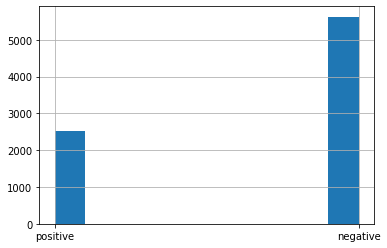

In [11]:
crisol.polaridad.hist()

In [12]:
crisol = crisol.sample(frac=1.0,)

In [64]:
from datasets import load_dataset

noticias = load_dataset("mlsum", "es", split="train[0:10000]")
records = [
    rb.TextClassificationRecord(
        inputs=noticia["summary"],
    )
    for noticia in noticias
] ; len(records)

10000

In [65]:
rb.delete(name="noticias_en_es_weak_supervision")
rb.log(records, name="noticias_en_es_weak_supervision")


10000 records logged to http://localhost:6900/noticias_en_es_weak_supervision


BulkResponse(dataset='noticias_en_es_weak_supervision', processed=10000, failed=0)

In [85]:
from rubrix.labeling.text_classification import Rule, WeakLabels

terminos_positivos = crisol.query("polaridad == 'positive'")[0:1000].values
terminos_negativos = crisol.query("polaridad == 'negative'")[0:2000].values

In [86]:
rules = []

for termino, polaridad in terminos_positivos:
    rules.append(
        Rule(query=f"{termino}", label="Positivo")
    )
    
for termino, polaridad in terminos_negativos:
    rules.append(
        Rule(query=f"{termino}", label="Negativo")
    )

In [87]:
weak_labels = WeakLabels(rules=rules, dataset="noticias_en_es_weak_supervision")

In [84]:
weak_labels.summary()

ValueError: Shape of passed values is (7001, 4), indices imply (6997, 4)

In [76]:
from snorkel.labeling.model import LabelModel

# train our label model
label_model = LabelModel()
label_model.fit(L_train=weak_labels.matrix(has_annotation=False))

# check its performance
#label_model.score(L=weak_labels.matrix(has_annotation=True), Y=weak_labels.annotation())

In [77]:
# Get the part of the weak label matrix that has no corresponding annotation
train_matrix = weak_labels.matrix(has_annotation=False)

# Get predictions from our label model
predictions = label_model.predict_proba(L=train_matrix)
predicted_labels = label_model.predict(L=train_matrix)

preds = [[('Positivo', pred[0]), ('Negativo', pred[1])] for pred in predictions]

# Get the records that do not have an annotation
train_records = weak_labels.records(has_annotation=False)

# Add the predictions to the records
def add_prediction(record, prediction):
    record.prediction = prediction
    return record

train_records_with_lm_prediction = [
    add_prediction(rec, pred)
    for rec, pred, label in zip(train_records, preds, predicted_labels)
    if label != weak_labels.label2int[None] # exclude records where the label model abstains
]

# Log a new dataset to Rubrix
rb.delete(name="noticias_en_es_snorkel")
rb.log(train_records_with_lm_prediction, name="noticias_en_es_snorkel")


2817 records logged to http://localhost:6900/noticias_en_es_snorkel


BulkResponse(dataset='noticias_en_es_snorkel', processed=2817, failed=0)

## Reconocimiento de entidades

In [4]:
import spacy
import rubrix as rb

from datasets import load_dataset

nlp = spacy.load("es_core_news_md")
nlp = rb.monitor(nlp, dataset="noticias_en_es_ner", sample_rate=1.0)

dataset = load_dataset("mlsum", "es", split="test[10000:]")

Reusing dataset mlsum (/Users/dani/.cache/huggingface/datasets/mlsum/es/1.0.0/77f23eb185781f439927ac2569ab1da1083195d8b2dab2b2f6bbe52feb600688)


In [ ]:
def extract_entities(record):
    docs = nlp.pipe(record["summary"])
    return {"processed": [doc.text for doc in docs]}

dataset.map(
    extract_entities,
    batched=True, 
    batch_size=32
)

In [7]:
from rubrix.metrics.token_classification import *

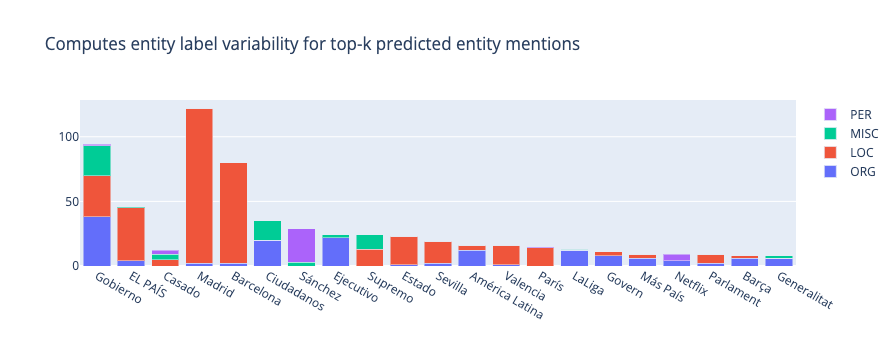

In [9]:
entity_consistency(name="noticias_en_es_ner", mentions=100).visualize()

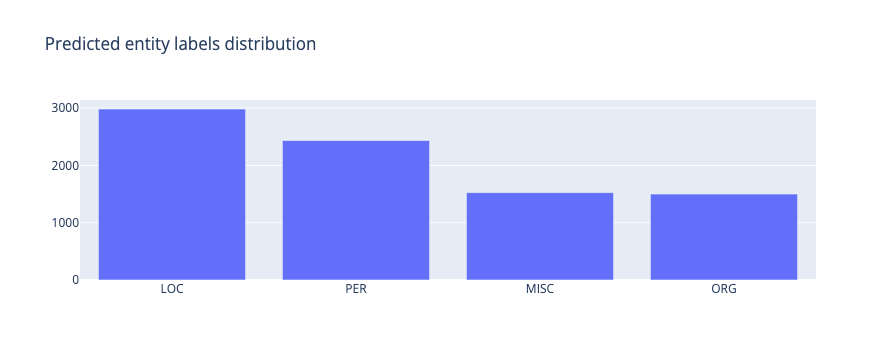

In [13]:
entity_labels(name="noticias_en_es_ner").visualize()

# **Caso práctico 3: Resúmenes automáticos**

## Revisión de datos de entrenamiento

In [21]:
from datasets import load_dataset

dataset = load_dataset("mlsum", "es", split="train[10000:]")

Reusing dataset mlsum (/Users/dani/.cache/huggingface/datasets/mlsum/es/1.0.0/77f23eb185781f439927ac2569ab1da1083195d8b2dab2b2f6bbe52feb600688)


In [22]:
records = [
    rb.Text2TextRecord(
        text=noticia["text"],
        annotation=noticia["summary"],
        metadata={
            "summary_len": len(noticia["summary"]), 
            "text_len": len(noticia["text"])
        }
    )
    for noticia in dataset
] ; len(records)

256367

In [ ]:
rb.log(records[0:100000], name="noticias_en_es_resumenes")

## Anexo: Leer y guardar los tweets en probas

In [ ]:
!wget https://github.com/garnachod/TwitterSentimentDataset/raw/master/tweets_clean.txt
!wget https://github.com/garnachod/TwitterSentimentDataset/raw/master/tweets_pos_clean.txt
!wget https://github.com/garnachod/TwitterSentimentDataset/raw/master/tweets_neg_clean.txt

In [ ]:
df = pd.DataFrame({"text": []})
for source in ["tweets_pos_clean.txt", "tweets_neg_clean.txt", "tweets_clean.txt"]:
    with open(source, "r") as file:
        tweets = file.readlines()
        tweets = pd.DataFrame({"text": tweets})
        tweets["source"] = source
        df = pd.concat([df, tweets])
df.to_csv("tweets_en_es.csv")

In [ ]:
dataset = rb.load("tuits_en_es")

In [ ]:
dataset.to_csv("tweets_en_es")

# Caso práctico 3: Lazaro

In [ ]:
df = pd.read_json("../tutorials/data/lazaro_training.jsonl", orient="records", lines=True)

In [ ]:
df.head()

In [ ]:
df.section.hist()

## Caso de uso 1: Anotación manual y revisión para NER 

In [ ]:
recor

## Caso de uso 2: Pre-anotación y evaluación con un clasificador zero-shot

In [ ]:
from transformers import pipeline
from datasets import Dataset, load_dataset

import rubrix as rb


#dataset = Dataset.from_csv("your_dataset.csv")
dataset = load_dataset("ag_news", split="test[0:10]")
nlp = pipeline("sentiment-analysis")
nlp = rb.monitor(task_model=nlp, dataset="nlp_monitoring")


In [ ]:
dataset.map(lambda example: {"prediction": nlp(example["text"])})

## Material presentación

In [ ]:
import rubrix as rb

In [ ]:
texto = "Rubrix, herramienta Python desarrollada por Recognai, es el resultado de casi 5 años desarrollando soluciones de PLN para empresas, contribuyendo a librerías de código abierto como spaCy o AllenNLP y publicando modelos pre-entrenados en Hugging Face como el reciente Selectra."

In [ ]:
import spacy

nlp = spacy.load("es_core_news_md")
nlp = rb.monitor(task_model=nlp, dataset="hola", sample_rate=1.0)

In [ ]:
nlp(texto)

In [ ]:
from transformers import pipeline

nlp = pipeline("zero-shot-classification", model="Recognai/zeroshot_selectra_medium")
nlp = rb.monitor(task_model=nlp, dataset="charla_textcat", sample_rate=1.0)

In [ ]:
nlp(texto, candidate_labels=["tecnología", "cultura", "educación", "sociedad", "política"])

In [ ]:
record = rb.Text2TextRecord(
    text=texto,
    prediction=[("Rubrix es una herramienta Python", 0.8)]
)
rb.log(record, name="charla_textsum")